# Differential Equation Machine

### batching 

* allows for calculations to be done in parallel
* distibuted caluclations
* scaleable
* gives more flexability
* Batch training allows for more Efficient training
* 


### common issues

* dead network problem where an initial bias is set to zero and is propegated through the network. the model doesnt learn

# Abstractions

* neuron
* layer
* activation function
* pack propoagation
* gradient decent
* embedder - *ie onehot embedding for normalizing and scaling
* 


### Optimizers
- _Gradient_ : First-order derivative for a multivariate objective function.
- _Step Size (alpha)_ : Hyperparameter that controls how far to move in the search space against the gradient each iteration of the algorithm.
- algorithms that organize how nerons get adjusted to training data
- function that iterates though nerons and changes weights, biases, and activation fucntions to fit data
- Stochastic Gradient Decent
- Adaptive Movement Estimation (Adam)

### Activation Functions Layer

* ReLu
    - efficient
    - popular
* Step - Hevicide Function
    - systen if functions that creates segments with steps (if theta-x > theta-z)
* Sigmoid
    - slower than relu
    - vanishing gradients
* Softmax
    - used for classification

* every neuron in the network has an activation function
* connects two nerons

* why use it?
    - allows for model to segment its self and have each neruon self determine a portion of the data
    - with only linear functions, the network can only learn linear data
    - using non linear functions allows for fitting of more complex data



### Loss

* Categorical Cross Entropy
 - takes an output from the model, does softmax, compares the normalized output to groundtruth, then finally returns how wrong the values are.


### Normalization

* y= e^x
* helps encode data with more quality.
* OneHotEncoding - encodes data into categorical numbers so that linear neral nets can train on classes.
* "Bias Trick": adding an extra dimension to the input data (usallly a 1) to implify bias.

### BackPropagation

* the process of taking the gradient of the loss with respect to weights, and the gradient of the loss with respect to inputs.

* gradient derived from the composite function of all the layers.



"Backpropagation is really one instance of a more general technique called "reverse mode differentiation" to compute derivatives of functions represented in some kind of directed graph form." - 3BlueOneBrown (Deep Learning Chapter 4)

"Essentially, backpropagation evaluates the expression for the derivative of the cost function as a product of derivatives between each layer from left to right – "backwards" – with the gradient of the weights between each layer being a simple modification of the partial products (the "backwards propagated error)."

### Gradient Decent

* consider a chain of nerons
    - how can you find the rate each neron changes given an expected output

* Chain rule: by taking the derivative of composite functions - ie f'(g'(x)) we can understand how each funciton influences the next.

* Decay: Slowly reducing the step size while training. Instead of walking any direction randomly. You slow your steps over time to walk towards the minima more precisly.

* Momentum. Using the Moving Average of gradient decent to smooth the direction of 

In [ ]:
import numpy as np
import nnfs
import math


E = math.e

# sets default configuration for numpy to avoid data type errors
nnfs.init() 

np.random.seed(42)

class DenseLayer:
    def __init__(self, n_inputs, n_neurons):
        self.weights = self.weights = np.random.randn(n_inputs, n_neurons) * np.sqrt(2 / n_inputs)
        self.biases = np.zeros((1, n_neurons))
        self.bias_momentum = np.zeros_like(self.biases)
        self.weight_momentum = np.zeros_like(self.weights)
        
    def forward(self, inputs):
        self.inputs = inputs
        self.output = np.dot(inputs, self.weights) + self.biases
    # takes the derivaties of the previous layer
    
    def backward(self, dvalues):
        self.dweights = np.dot(self.inputs.T, dvalues)
        self.dbiases = np.sum(dvalues, axis=0, keepdims=True)
        self.dinputs = np.dot(dvalues, self.weights.T)

    def __repr__(self):
        # construct and return a string that represents the network
        # architecture
        return "NeuralNetwork: {}".format("-".join(str(l) for l in self.weights))

class ReLu:
    def forward(self, inputs):
        self.inputs = inputs
        self.output = np.maximum(0, inputs)
    
    def backward(self, dvalues):
        self.dinputs = dvalues.copy()
        
        #zero the gradient where inputs are negative
        self.dinputs[self.inputs <= 0] = 0

class Sigmoid:
    def forward(self, inputs):
        self.output = 1/(1 + np.exp(-inputs))

class Softmax:
    #safe softmax prevents memory overflow
    def forward(self, inputs):
        exp_values = np.exp(inputs - np.max(inputs, axis=1, keepdims=True))
        
        probabilities = exp_values / np.sum(exp_values, axis=1, keepdims=True)
        self.output = probabilities

class Loss:
    def calculate(self, y, output):
        sample_losses = self.forward(y, output)
        data_loss = np.mean(sample_losses)
        return data_loss

class CategoricalCrossEntropyLoss(Loss):
    def forward(self, y_truth,  y_probs):
        samples = len(y_probs)
        y_pred_clipped = np.clip(y_probs, 1e-7, 1-1e-7)
        
        if len(y_truth.shape) == 1: #probabilites for target values, only if categorical labels
            correct_confidences = y_pred_clipped[range(samples), y_truth]
            
        if len(y_truth.shape) == 2: # Masking for one hot encoding
            correct_confidences = np.sum(y_pred_clipped*y_truth, axis=1)
            
        negative_log_likelihoods = -np.log(correct_confidences)
        return negative_log_likelihoods
    
    def backward(self, y_truth, y_probability):
        samples = len(y_probability)
        if len(y_truth.shape) == 1:
            y_truth = np.eye(y_probability.shape[1])[y_truth]
        
        self.dinputs = -y_truth/ y_probability
        self.dinputs = self.dinputs / samples

class Fast_CCE_Loss: #composition
    def __init__(self):
        self.activation = Softmax()
        self.loss = CategoricalCrossEntropyLoss()

    def forward(self, inputs, y_true):
        self.activation.forward(inputs)
        self.output = self.activation.output
        return self.loss.calculate(y_true, self.output)

    def backward(self, dvalues, y_truth):
        samples = len(dvalues)
        #one-hot encoding conversion
        if len(y_truth.shape) == 2:
            y_truth = np.argmax(y_truth, axis=1)
        self.dinputs = dvalues.copy()
        self.dinputs[range(samples), y_truth] -= 1
        self.dinputs = self.dinputs / samples

class Gradient_Decent:
    def  __init__(self, learning_rate=1, decay=0, epoch=0 ,momentum=0):
        self.learning_rate= learning_rate
        self.current_rate = learning_rate
        self.decay=decay
        self.epoch=epoch
        self.momentum=momentum
        
    def set_decay(self):
        if self.decay:
            self.current_rate = self.learning_rate*(1 / (1 + self.decay * self.epoch))
        
    def update_parameters(self, layer: DenseLayer):
        updated_weights = self.momentum * layer.weight_momentum - self.current_rate * layer.dweights
        layer.weight_momentum = updated_weights
        
        updated_biases = self.momentum * layer.bias_momentum - self.current_rate * layer.dbiases
        layer.bias_momentum = updated_biases
        
        layer.weights += updated_weights
        layer.biases  += updated_biases
        
# TODO: find a way to better format the layers and activations. maybe do it in a way that
# accepts a dictionary of objects, check for a design pattern

# making a small network
class MyFirstNeuralNetwork:
    def __init__(self, training, y):
        self.data = training
        self.truth = y
        self.input_layer = DenseLayer(2,64)
        self.hidden_layer = DenseLayer(64,3)
        self.activation1 = ReLu()
        self.activation2 = Fast_CCE_Loss()


    def forward(self):
        #layer pass
        self.input_layer.forward(self.data)
        self.activation1.forward(self.input_layer.output)
        
        self.hidden_layer.forward(self.activation1.output)
        self.loss = self.activation2.forward(self.hidden_layer.output, self.truth)
        
        #forward pass results
        self.probabilities = self.activation2.output
        self.predictions = np.argmax(self.probabilities, axis=1)
        if len(self.truth.shape) == 2:
            self.truth = np.argmax(self.truth, axis=1)
        self.accuracy = np.mean(self.predictions == self.truth)
        
    def backward(self):
        self.activation2.backward(self.probabilities, self.truth)
        self.hidden_layer.backward(self.activation2.dinputs)
        self.activation1.backward(self.hidden_layer.dinputs)
        self.input_layer.backward(self.activation1.dinputs)
        
        


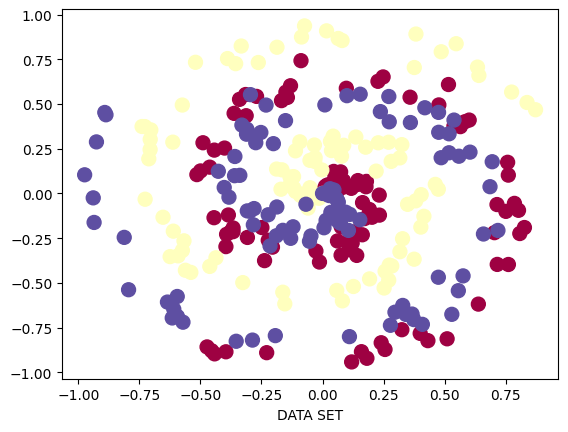

Epoch:0, Loss:1.0978277921676636, Accuracy:0.41333333333333333, Learning Rate:1
Epoch:100, Loss:1.0446697473526, Accuracy:0.4633333333333333, Learning Rate:0.9099181073703367
Epoch:200, Loss:1.0363378524780273, Accuracy:0.4633333333333333, Learning Rate:0.8340283569641367
Epoch:300, Loss:1.0403926372528076, Accuracy:0.5233333333333333, Learning Rate:0.7698229407236336
Epoch:400, Loss:1.0322530269622803, Accuracy:0.52, Learning Rate:0.7147962830593281
Epoch:500, Loss:1.0109736919403076, Accuracy:0.4866666666666667, Learning Rate:0.66711140760507
Epoch:600, Loss:0.9691975712776184, Accuracy:0.5333333333333333, Learning Rate:0.6253908692933083
Epoch:700, Loss:0.9502272605895996, Accuracy:0.53, Learning Rate:0.5885815185403178
Epoch:800, Loss:0.9434781074523926, Accuracy:0.49, Learning Rate:0.5558643690939411
Epoch:900, Loss:0.9324016571044922, Accuracy:0.56, Learning Rate:0.526592943654555
Epoch:1000, Loss:0.9457777142524719, Accuracy:0.55, Learning Rate:0.5002501250625312
Epoch:1100, Los

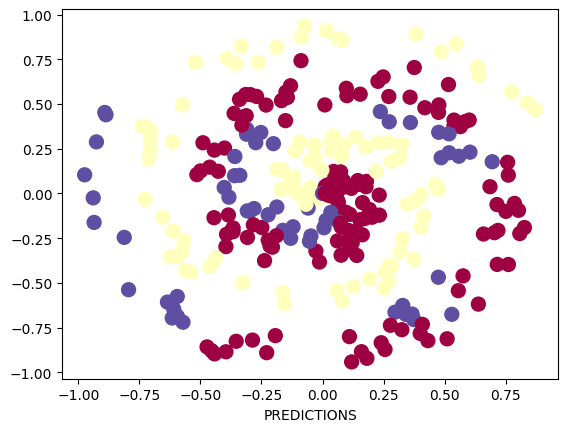

In [ ]:
import numpy as np
from nnfs.datasets import spiral_data
import matplotlib.pyplot as plt
plt.subplots()

np.random.seed(42)

X, y = spiral_data(samples=100, classes=3)

plt.scatter(X[:, 0], X[:, 1], c=y, s=100, cmap=plt.cm.Spectral)
plt.xlabel("DATA SET")
plt.show()

nn = MyFirstNeuralNetwork(X, y)
optimizer = Gradient_Decent(decay=1e-3)

for epoch in range(10000):
    optimizer.epoch = epoch
    nn.forward()
    
    if epoch%100 == 0:
        print(f'Epoch:{epoch}, Loss:{nn.loss}, Accuracy:{nn.accuracy}, Learning Rate:{optimizer.current_rate }')
    nn.backward()
    optimizer.set_decay()
    optimizer.update_parameters(nn.hidden_layer)
    optimizer.update_parameters(nn.input_layer)
    
   





plt.scatter(X[:, 0], X[:, 1], c= nn.predictions, s=100, cmap=plt.cm.Spectral)
plt.xlabel("PREDICTIONS")
plt.show()



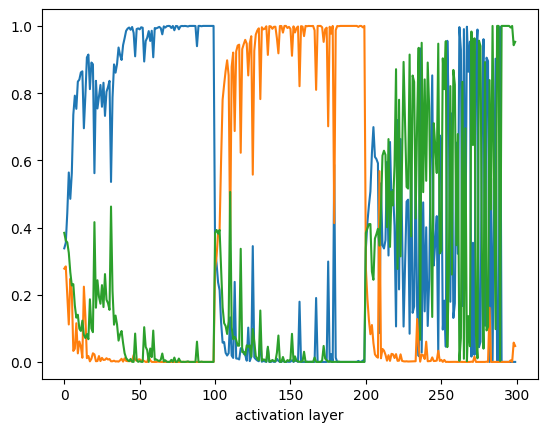

Text(0.5, 0, 'PREDICTIONS')

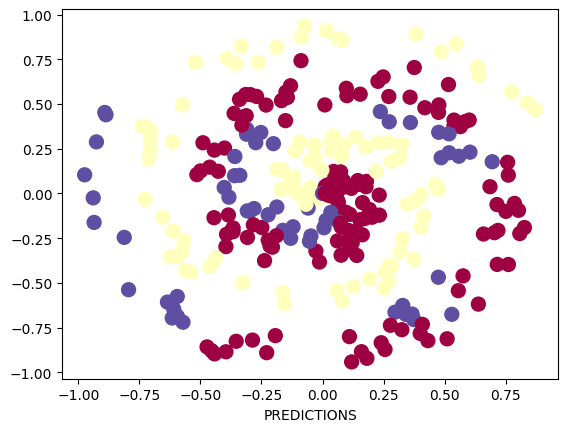

In [3]:
plt.subplot()
plt.plot(nn.activation2.output)
plt.xlabel("activation layer")
plt.show()
plt.scatter(X[:, 0], X[:, 1], c= nn.predictions, s=100, cmap=plt.cm.Spectral)
plt.xlabel("PREDICTIONS")


In [4]:
loss = CategoricalCrossEntropyLoss()
tensor1 =np.array([[0.1,0.8,0.1],[0.1,0.5,0.4],[0.8,0.1,0.1]])
truth = np.array([1,2,1])
print(loss.calculate(tensor1, truth)) 


1.0000000487334986e-07


In [5]:
print(y)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2]


In [6]:
print(X)

[[ 0.00000000e+00  0.00000000e+00]
 [ 3.21944972e-04  1.00958785e-02]
 [ 1.01406239e-02  1.74725316e-02]
 [ 2.65020747e-02  1.46940006e-02]
 [ 1.14360163e-02  3.87518257e-02]
 [ 1.91071313e-02  4.67512310e-02]
 [ 5.96790314e-02  1.05597246e-02]
 [ 6.27165437e-02  3.26515697e-02]
 [ 4.38338593e-02  6.78862184e-02]
 [ 8.40679333e-02  3.45983505e-02]
 [ 7.09227771e-02  7.19235763e-02]
 [ 8.55133608e-02  7.09446520e-02]
 [ 1.17804065e-01  2.85408571e-02]
 [ 4.58267257e-02  1.23057097e-01]
 [ 7.41181001e-02  1.20434493e-01]
 [ 1.43003151e-01  5.00693619e-02]
 [ 1.44741133e-01  7.19012469e-02]
 [ 1.63869113e-01 -5.13195954e-02]
 [ 1.77950650e-01  3.73017080e-02]
 [ 1.79767802e-01  6.72050044e-02]
 [ 7.65377581e-02 -1.86960250e-01]
 [ 1.92139819e-01 -8.98760334e-02]
 [ 1.72066405e-01 -1.40626699e-01]
 [ 2.32136816e-01 -9.30482522e-03]
 [ 2.02611968e-01 -1.33108616e-01]
 [ 1.34325907e-01 -2.13835344e-01]
 [ 2.32951865e-01 -1.21268228e-01]
 [ 6.12381697e-02 -2.65763164e-01]
 [ 1.62863359e-01 -2

# Chatgpt Generated Tests

In [7]:
# import numpy as np
# import nnfs
# import math


# E = math.e

# # sets default configuration for numpy to avoid data type errors
# nnfs.init() 

# np.random.seed(42)

# class DenseLayer:
#     def __init__(self, n_inputs, n_neurons):
#         self.weights = self.weights = np.random.randn(n_inputs, n_neurons) * np.sqrt(2 / n_inputs)
#         self.biases = np.zeros((1, n_neurons))

#     def forward(self, inputs):
#         self.inputs = inputs
#         self.output = np.dot(inputs, self.weights) + self.biases
#     # takes the derivaties of the previous layer
    
#     def backward(self, dvalues):
#         self.dweights = np.dot(self.inputs.T, dvalues)
#         self.dbiases = np.sum(dvalues, axis=0, keepdims=True)
#         self.dinputs = np.dot(dvalues, self.weights.T)
#         print(self.dweights)
#         # print(self.dbiases)
#     def __repr__(self):
#         # construct and return a string that represents the network
#         # architecture
#         return "NeuralNetwork: {}".format("-".join(str(l) for l in self.weights))

# class ReLu:
#     def forward(self, inputs):
#         self.inputs = inputs
#         self.output = np.maximum(0, inputs)
    
#     def backward(self, dvalues):
#         self.dinputs = dvalues.copy()
        
#         #zero the gradient where inputs are negative
#         self.dinputs[self.inputs <= 0] = 0

# class Sigmoid:
#     def forward(self, inputs):
#         self.output = 1/(1 + np.exp(-inputs))

# class Softmax:
#     #safe softmax prevents memory overflow
#     def forward(self, inputs):
#         exp_values = np.exp(inputs - np.max(inputs, axis=1, keepdims=True))
        
#         probabilities = exp_values / np.sum(exp_values, axis=1, keepdims=True)
#         self.output = probabilities

# class Loss:
#     def calculate(self, y, output):
#         sample_losses = self.forward(y, output)
#         data_loss = np.mean(sample_losses)
#         return data_loss

# class CategoricalCrossEntropyLoss(Loss):
#     def forward(self, y_truth,  y_probs):
#         samples = len(y_probs)
#         y_pred_clipped = np.clip(y_probs, 1e-7, 1-1e-7)
        
#         if len(y_truth.shape) == 1: #probabilites for target values, only if categorical labels
#             correct_confidences = y_pred_clipped[range(samples), y_truth]
            
#         if len(y_truth.shape) == 2: # Masking for one hot encoding
#             correct_confidences = np.sum(y_pred_clipped*y_truth, axis=1)
            
#         negative_log_likelihoods = -np.log(correct_confidences)
#         return negative_log_likelihoods
    
#     def backward(self, y_truth, y_probability):
#         samples = len(y_probability)
#         if len(y_truth.shape) == 1:
#             y_truth = np.eye(y_probability.shape[1])[y_truth]
        
#         self.dinputs = -y_truth/ y_probability
#         self.dinputs = self.dinputs / samples

# class Fast_CCE_Loss: #composition
#     def __init__(self):
#         self.activation = Softmax()
#         self.loss = CategoricalCrossEntropyLoss()

#     def forward(self, inputs, y_true):
#         self.activation.forward(inputs)
#         self.output = self.activation.output
#         return self.loss.calculate(y_true, self.output)

#     def backward(self, dvalues, y_truth):
#         samples = len(dvalues)
#         #one-hot encoding conversion
#         if len(y_truth.shape) == 2:
#             y_truth = np.argmax(y_truth, axis=1)
#         self.dinputs = dvalues.copy()
#         self.dinputs[range(samples), y_truth] -= 1
#         self.dinputs = self.dinputs / samples

# class Gradient_Decent:
#     def  __init__(self, learning_rate = 0.01):
#         self.learning_rate= learning_rate
        
#     def update_parameters(self, layer: DenseLayer):
#         layer.weights += -self.learning_rate * layer.dweights
#         layer.biases += -self.learning_rate * layer.dbiases
        
# # TODO: find a way to better format the layers and activations. maybe do it in a way that
# # accepts a dictionary of objects, check for a design pattern

# # making a small network
# class MyFirstNeuralNetwork:
#     def __init__(self, training, y):
#         self.data = training
#         self.truth = y # Keep original y as self.truth
#         self.input_layer = DenseLayer(2,3)
#         self.hidden_layer = DenseLayer(3,3)
#         self.activation1 = ReLu()
#         self.activation2 = Fast_CCE_Loss()

#     def forward(self):
#         self.input_layer.forward(self.data)
#         self.activation1.forward(self.input_layer.output)

#         self.hidden_layer.forward(self.activation1.output)
#         # Pass self.truth as is; Fast_CCE_Loss.forward handles 1D/2D conversion for loss calculation
#         self.loss = self.activation2.forward(self.hidden_layer.output, self.truth)

#         self.probabilities = self.activation2.output
#         self.predictions = np.argmax(self.probabilities, axis=1)

#         # Store 1D true labels for accuracy and backward pass explicitly
#         if len(self.truth.shape) == 2:
#             self.truth_labels = np.argmax(self.truth, axis=1)
#         else:
#             self.truth_labels = self.truth # If original y was already 1D
#         self.accuracy = np.mean(self.predictions == self.truth_labels)

#     def backward(self):
#         # Always pass 1D true labels to Fast_CCE_Loss.backward for consistency
#         self.activation2.backward(self.probabilities, self.truth_labels)
#         self.hidden_layer.backward(self.activation2.dinputs)
#         self.activation1.backward(self.hidden_layer.dinputs)
#         self.input_layer.backward(self.activation1.dinputs)
        
